In [1]:
# pip install --upgrade xgboost scikit-learn

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
target = df.columns.tolist()[-1]
print(df.shape)
df.head()

(593994, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


* `target = df.columns.tolist()[-1]` 把df的列名转成列表后的最后一个提取出来当作新变量  
  * 要根据实际数据来看，这里的数据中最后一列是用户是否还款所以提取出来，如果是第一列的话可能要把‘-1’改成1或者0


# 构造函数

In [5]:
def create_frequency_features(df, df_test):
    """
    添加频率和分箱特征

    - 对于类别变量, 增加一个新一个变量： <col>_freq = 每个值在训练数据中出现的频率。
    - 对于数值变量, 值分割成5,10,15分位数箱。
    """
    # 为新特征预分配dataframe以避免碎片化
    freq_features_train = pd.DataFrame(index=df.index)
    freq_features_test = pd.DataFrame(index=df_test.index)
    bin_features_train = pd.DataFrame(index=df.index)
    bin_features_test = pd.DataFrame(index=df_test.index)

    for col in cols:
        # --- 频率编码 Frequency encoding ---
        freq = df[col].value_counts()
        df[f"{col}_freq"] = df[col].map(freq)
        freq_features_test[f"{col}_freq"] = df_test[col].map(freq).fillna(freq.mean())

        # --- 分箱 Quantile binning for numeric columns ---
        if col in num:
            for q in [5, 10, 15]:
                try:
                    train_bins, bins = pd.qcut(df[col], q=q, labels=False, retbins=True, duplicates="drop")
                    bin_features_train[f"{col}_bin{q}"] = train_bins
                    bin_features_test[f"{col}_bin{q}"] = pd.cut(df_test[col], bins=bins, labels=False, include_lowest=True)
                except Exception:
                    bin_features_train[f"{col}_bin{q}"] = 0
                    bin_features_test[f"{col}_bin{q}"] = 0

    # 把新创造的变量合并在一起 Concatenate all new features at once
    df = pd.concat([df, freq_features_train, bin_features_train], axis=1)
    df_test = pd.concat([df_test, freq_features_test, bin_features_test], axis=1)

    return df, df_test

### 频率编码
1. ` for col in cols:` 其中`cols`,是在下文定义的变量，范围是数据中剔除了`target`和`id`列之后构成的列表。能够使循环遍历全部列名用于频率编码构建新变量
2. `freq = df[col].value_counts()` 在特定次数的循环中，把对某一列名进行计数形成新变量`freq`用于后续`map()`的检索  
**·** 这里的`freq`是一个序列值，有一点点像字典，存在配对。但实际上记录的`dtype`是`int64`
3. `df[f"{col}_freq"] = df[col].map(freq)`,首先df[column_name]可以用于访问或创建指定列，这里是在创建新的列名；其次注意不要把`col`当成数值在遍历，因为我们的范围`cols`是一整个字符串列表，所以`col`遍历的时候也会是一个个字符串名字；理解了这个之后，就能理解用`f"{col}_freq"`来创建新变量，`f"…`表示这是一个f-string、`{col}`是f-string表达式，会被实际的值替换；最后就是.map()是针对序列值进行遍历映射的工具
4. `freq_features_test[f"{col}_freq"`首先要理解预设的四个空DataFrame是什么东西？它是一个对原数据组的index的提取，但是里面没有列名，也没有值，就像一个excel表格，只有id或者只有序号的空表格；其次我们也是跟上一步一样去创造列名，但是因为我们不知道**测试集的时候会不会有新数据**，所以在测试集对应的`.map()`遍历与`de_test[col]`的替换中使用了`.fillna(freq.mean())`去用该列名的频率均值去替换空值  
    **·** 本质上其实是在用均值代替空值来实现数据处理，只是因为我们对测试集的未知导致需要加上更严谨的限定与检索
### 分箱
1. `train_bins, bins = pd.qcut(df[col], q=q, labels=False, retbins=True, duplicates="drop")` 首先这是一个多重赋值(元组解包)，使用`qcut`时，将`retbins`参数设置为`True`时，方法会返回两个值，一个是**分箱编号**，比如：(0,0,1,2,3,3)→表示分了四个箱，各自的长度为2,1,1，2。另一个是**分箱边界点**,比如(3.5,5,7.5,10)…所以用这个方式能直接赋值；其次`labels=False`让方法**不会**以分箱区间的方式返回分箱编号，比如本来会返回[(0.999, 3.5] (0.999, 3.5]  (3.25, 5.0] ... (7.5, 10.0] (7.5, 10.0]]改为只返回对应编号 `duplicates = drop`会删去重复边界，如果不写drop的话会在遇见重复边界时报错。
2. `bin_features_train[f"{col}_bin{q}"] = train_bins`跟上面频率编码的加入值的原理一致，就是提前设立空表，然后用f-string创建新变量，并用等号赋值。
3. `bin_features_test[f"{col}_bin{q}"] = pd.cut(df_test[col], bins=bins, labels=False, include_lowest=True)`首先一样是对空表进行加变量；其次利用`cut`函数是为了利用我们第一步针对训练集分好的分箱边界，对测试集的同一位置进行分箱，避免因为两个数据集的数据量不一样导致额外的qcut反而cut了完全不同意义的分箱出来。
4. `except`是防报错机制，避免无法分箱。

### 合并
1. 利用`concat()`把利用特征工程函数的创造的变量，添加进原本的训练集和测试集中；其中`axis =1`保证了列名是横向添加，不然就是垂直添加。垂直添加的话就会有很多多出来的`id`？
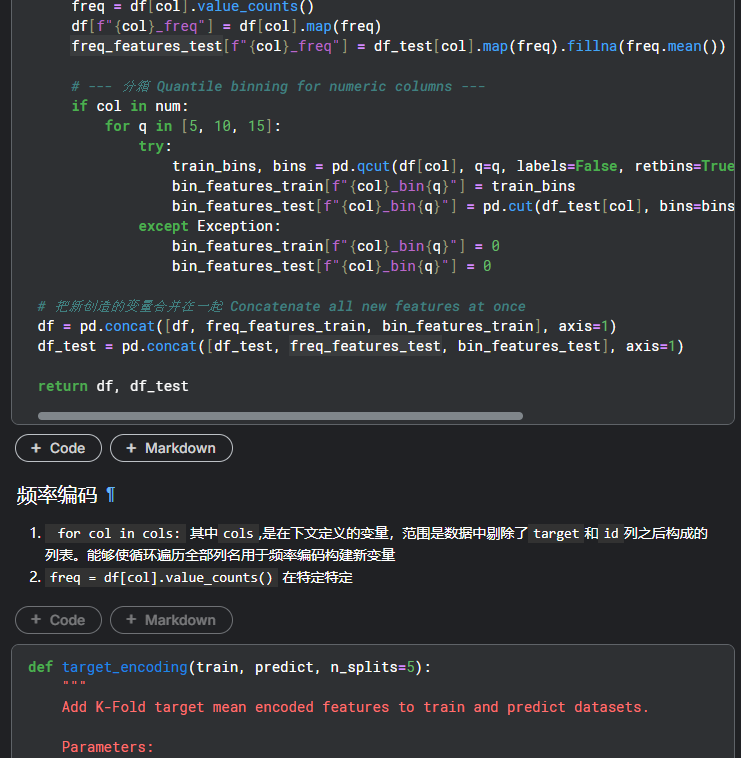
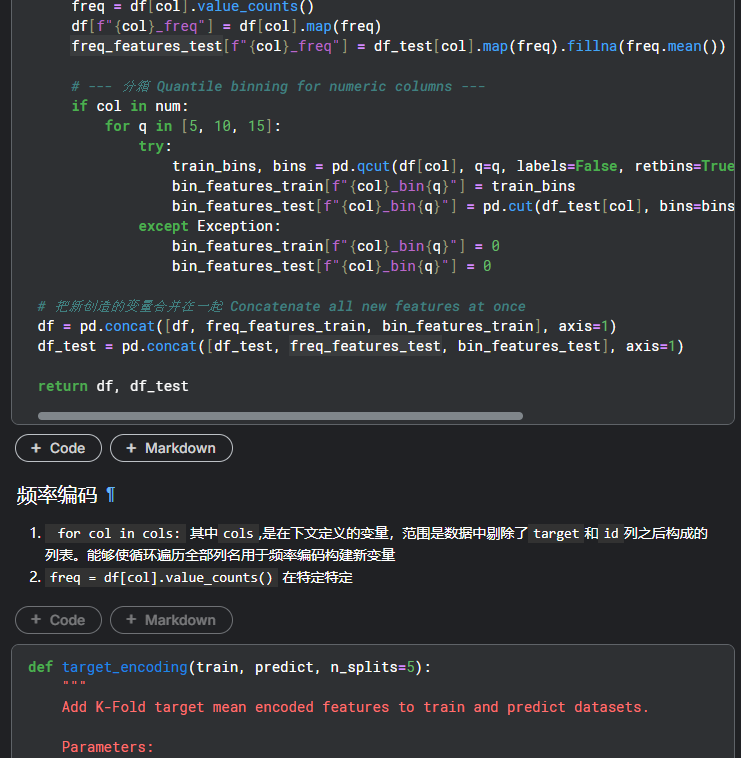

In [6]:
def target_encoding(train, predict, n_splits=5):
    """
    添加K-Fold目标平均编码特征来训练和预测数据集。    
    
    参数:
    - train: 训练集
    - predict: 测试集
    - target: name of the target column
    - n_splits: K-Fold编码的折叠数
    
    Returns:
    -使用新的均值编码特征训练和预测dataframe
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mean_features_train = pd.DataFrame(index=train.index)
    mean_features_test = pd.DataFrame(index=predict.index)

    for col in cols:
        # 当前列创建存储编码结果的数组
        mean_encoded = np.zeros(len(train))
        # K折交叉验证循环
        for tr_idx, val_idx in kf.split(train):
            tr_fold = train.iloc[tr_idx]
            val_fold = train.iloc[val_idx]
            mean_map = tr_fold.groupby(col)[target].mean()
            mean_encoded[val_idx] = val_fold[col].map(mean_map)

        mean_features_train[f'mean_{col}'] = mean_encoded

        # --- 将全局均值映射应用于预测/测试数据---
        global_mean = train.groupby(col)[target].mean()
        mean_features_test[f'mean_{col}'] = predict[col].map(global_mean)

    # --- 在函数功能内直接合并新特征避免碎片化(爆仓) ---
    train = pd.concat([train, mean_features_train], axis=1)
    predict = pd.concat([predict, mean_features_test], axis=1)

    # 整理 Defragment
    train = train.copy()
    predict = predict.copy()
    #把处理后的训练集测试集返回出来
    return train, predict

### K-Fold交叉验证的优势
* 避免目标变量信息泄露到特征中
* 更稳健的编码，防止过拟合
* 提高模型泛化能力

### 目标编码
1. `kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)`这是在设定一个初始化kFold筛选器，让`splits`次数等于函数的参数值，这样方便我们在后续调用的时候进行设置；`shuffle=True`是对数据进行打乱来抽取，避免因为原本数据有自己的排序方式（时间，或者有规律地波动），提高交叉验证的可靠性；`ramdom_state=42`，这是设置随机种子，42是常用的默认值，想更改的话可以设置为任意整数
2. ` mean_encoded = np.zeros(len(train))`其中`np.zeros()`是分配全零(格式为浮点数0.0)的数组，而`len(train)`能够确认训练集的样本数量，这样就创造了一个大小整好能装下训练集数据的全零数据，类型数据为float64
3. `for tr_idx, val_idx in kf.split(train):`前两个是后续要接下的索引值idx，后面`.split(train)`是利用我们设置好的kF迭代器，对我们调用方法时输入的参数`train`进行迭代产生`(train_indices, validation_indices)`的数据元组，并用前两个变量进行接收
4. `tr_fold = train.iloc[tr_idx]`和`val_fold = train.iloc[val_idx]`就是使用`iloc`按整数位置索引选择相应训练集或者验证集fold的数据，这一步也可以说非常重要，因为kF.split中**返回的是一个索引值**，可以理解为书签，那么这样一个书签是不具备数据的含义的，所以要用iloc去检索到实际训练集中的数据是什么
5. `mean_map = tr_fold.groupby(col)[target].mean()`是为了计算分组的目标均值，首先`groupby(col)`能够针对当前循环特定变量创建一个对应分组；其次利用`[taget].mear()`去计算在对应的组内，目标变量的均值。这就是目标编码的核心：***即用目标变量的统计量编码分类特征***
6. `mean_encoded[val_idx] = val_fold[col].map(mean_map)`最后把计算好的均值数据，插入到进最开始新设置的空表中
7. 跳过有两行与上一函数类似功能的，利用F-string对只有索引值的空表格加入新变量的语句
8. `global_mean = train.groupby(col)[target].mean()`这一步是把没有k-Fold处理过的特定列数据，对应的目标变量的均值，计算出来，后续会套入进训练集与测试集中。至于为什么要这样？  
    **·** 是因为要满足：**训练时要模拟预测时的条件，但预测时只能用训练时获得的知识**。所以预测试我们其实是不知道目标值更不用提目标值的均值了，所以先用全局均值代替  
   **·** 目标编码的本质：**将分类信息转换为数值信息，我们需要把变量转换为数值信息**，然后供给模型学习，如果失去了全局均值，模型只能学习到变量信息，但是却无法把这个信息与均值进行比较评估，就无法达到学习的目的了。

# 数据处理

In [7]:
# Specific feature engineering（这里要思考看看能不能额外处理一下，保留评级信息）
df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
df_test['subgrade'] = df_test['grade_subgrade'].str[1:].astype(int)

In [8]:
# Identify feature提取特征，把无意义的id列和结果列先剔除
cols = df.drop(columns=[target,"id"]).columns.tolist()

In [9]:
# Categorical features
cat = [c for c in cols if df[c].dtype in ["object","category"]]

# Numerical features
num = [c for c in cols if df[c].dtype not in ["object","category","bool"]]

* 这里用到的是列表推导式 `[expression for item in iterable if condition]`
  * 对于`cols`中的每个列名`c`,如果它满足type = [对象或类别]，就保留（或者说是赋予cat这个变量中）
  * 对于cols`中的每个列名`c`,如果它满足type ≠ [对象或类别或者布尔值]，就保留（或者说是赋予num这个变量中）
  * 这里的`c`是可以随意替换的，他只是一个变量的名字

In [10]:
# Creating new features based on the frequency of numerical features
df, df_test = target_encoding(df, df_test, 10)
df, df_test = create_frequency_features(df, df_test)

* 在这里真正调用了上面两个函数
* 参数10，在这里是K-fold折几折的意思，默认值是5

In [11]:
# Preparing categorical features
df[cat], df_test[cat] = df[cat].astype("category"), df_test[cat].astype("category")

* 为什么要将上面已经筛选下来的object类型和category类型一并转换成category类型呢？
  * 这是因为XGBoost可以**直接处理category**类型，无需one-hot编码

In [12]:
# Dropping unnecessary columns
remove = ["education_level","loan_purpose", "grade_subgrade", "interest_rate", "marital_status",
          "gender", "employment_status_freq", "credit_score_bin5",  "loan_amount_bin5",
          "debt_to_income_ratio_bin5"]
df, df_test = df.drop(columns = remove), df_test.drop(columns = remove)

# Dropping ID and duplicates
df.drop(columns="id", inplace=True)
df.drop_duplicates(inplace=True)

* 在`remove`中删除的字段，包括了原本数据的列名，因为我们已经基于原列名，利用特征工程产生了一堆新的变量，再把原列名纳入模型中就会导致信息其实是重复了
  * 但是笔者也不知道为什么要删除`_bin5`五分箱的若干变量（没有全删），以及为什么删除`employment_status_freq`
* 之前drop的是列名的列表，跟原数据df无关，所以这里要再drop一次`id`
* 在这里使用drop_duplicates是为了保险，实际上并没有发现有重复的列名

In [13]:
print(df.columns.tolist())
df.head()

['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'employment_status', 'loan_paid_back', 'subgrade', 'mean_annual_income', 'mean_debt_to_income_ratio', 'mean_credit_score', 'mean_loan_amount', 'mean_interest_rate', 'mean_gender', 'mean_marital_status', 'mean_education_level', 'mean_employment_status', 'mean_loan_purpose', 'mean_grade_subgrade', 'mean_subgrade', 'annual_income_freq', 'debt_to_income_ratio_freq', 'credit_score_freq', 'loan_amount_freq', 'interest_rate_freq', 'gender_freq', 'marital_status_freq', 'education_level_freq', 'loan_purpose_freq', 'grade_subgrade_freq', 'subgrade_freq', 'annual_income_bin5', 'annual_income_bin10', 'annual_income_bin15', 'debt_to_income_ratio_bin10', 'debt_to_income_ratio_bin15', 'credit_score_bin10', 'credit_score_bin15', 'loan_amount_bin10', 'loan_amount_bin15', 'interest_rate_bin5', 'interest_rate_bin10', 'interest_rate_bin15', 'subgrade_bin5', 'subgrade_bin10', 'subgrade_bin15']


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,annual_income,debt_to_income_ratio,credit_score,loan_amount,employment_status,loan_paid_back,subgrade,mean_annual_income,mean_debt_to_income_ratio,mean_credit_score,...,credit_score_bin10,credit_score_bin15,loan_amount_bin10,loan_amount_bin15,interest_rate_bin5,interest_rate_bin10,interest_rate_bin15,subgrade_bin5,subgrade_bin10,subgrade_bin15
0,29367.99,0.084,736,2528.42,Self-employed,1.0,3,0.717391,0.847944,0.891605,...,8,12,0,0,3,7,11,1,1,1
1,22108.02,0.166,636,4593.10,Employed,0.0,3,0.923077,0.627782,0.642255,...,1,2,0,1,3,6,9,1,1,1
2,49566.20,0.097,694,17005.15,Employed,1.0,5,NaN,0.815615,0.814907,...,5,8,6,9,0,0,1,3,3,3
3,46858.25,0.065,533,4682.48,Employed,1.0,1,NaN,0.902833,0.576642,...,0,0,0,1,4,9,14,0,0,0
4,25496.70,0.053,665,12184.43,Employed,1.0,1,0.937500,0.912490,0.836519,...,3,5,3,5,0,1,2,0,0,0


In [14]:
df.isnull().sum()[lambda x: x>0]

mean_annual_income           83864
mean_debt_to_income_ratio       25
mean_credit_score               14
mean_loan_amount             72382
mean_interest_rate              97
dtype: int64

In [15]:
df.shape

(593994, 45)

# 计算模型的效果

In [16]:
# def give_score():
dtrain = xgb.DMatrix(
    df.drop(columns=[target]),
    label=df[target],
    enable_categorical=True,
)

xgb_params = {
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 42,
    'scale_pos_weight':1,
    'min_child_weight': 89,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    "gamma":0,
    "max_leaves":8,#原本是4
    "reg_alpha":1.5,
    "reg_lambda":4.4,
    "scale_pos_weight":1,
    'learning_rate':0.1,#原本没有，默认0.3
}

cv_results = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    nfold=7,
    num_boost_round=20000,
    metrics='auc',
    verbose_eval=False,
    early_stopping_rounds=50,
)

print(cv_results.tail())

# Extract best boosting round
best_round = cv_results['test-auc-mean'].idxmax()
best_auc = cv_results['test-auc-mean'][best_round]
print(f"Best round: {best_round}, Best CV AUC: {best_auc:.7f}")

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
803        0.930243       0.000154       0.926709      0.001154
804        0.930247       0.000152       0.926709      0.001155
805        0.930250       0.000152       0.926709      0.001155
806        0.930254       0.000152       0.926709      0.001155
807        0.930257       0.000152       0.926709      0.001154
Best round: 807, Best CV AUC: 0.9267094


# 最终提交

In [17]:
# Prepare training data
X_train = df.drop(columns=target)
y_train = df[target]

# Train XGBoost model
model = XGBClassifier(**xgb_params, enable_categorical=True)
model.fit(X_train, y_train)

# Predict on test set
pred = model.predict_proba(df_test.drop(columns = "id"))[:, 1]

# Prepare submission
sub = pd.DataFrame({
    "id": df_test["id"],
    target: pred
})

# Save submission file
sub.to_csv("submission.csv", index=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:18:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
